# Chapter 3
## Discretization of a Convection-Diffusion Problem

We consider the equation
$$\begin{align}
-\mu\Delta u + v\cdot\nabla u &= f \quad \textrm{in } \Omega, \\
u &= g \quad \textrm{on } \partial\Omega.
\end{align}$$
The weak form is find $u_h\in V_h$ such that
$$\begin{equation}
\int_{\Omega}\mu\nabla u\nabla w dx + \int_{\Omega} v\cdot\nabla u w dx = \int_{\Omega} f w dx, \quad \forall w\in V_h,
\end{equation}$$
where $w$ are test functions. In one dimension on the unit interval with the boundary conditions $u(0) = 0$ and $u(1) = 1$, the problem has the analytical solution
$$u(x) = \frac{\exp{(-x/\mu)} - 1}{\exp{(-1/\mu)} - 1}.$$

## Exercise 3.1

Show that the matrix obtained from a central difference scheme applied to the operator $Lu = u_x$ is skew-symmetric. Furthermore, show that the matrix obtained by linear continuous Lagrange elements are also skew-symmetric. Remark: The matrix is only skew-symmetric in the interior of the domain, not at the boundary.

In [1]:
## Imports
import numpy   as np
import scipy   as sp
import dolfinx as dfx
import matplotlib.pyplot as plt


import ufl

from ufl      import grad, inner, div, dx
from mpi4py   import MPI
from petsc4py import PETSc

%matplotlib widget

In [2]:
## Exercise 3.1



Interpolate the solution for error calculation into higher-order space, because the exact solution is interpolated with an inherent error. Analytical solution and approximate solution must be in same space. Interpolation of the analytical solution has some error $E$ which can influence the total error $e_h + E$, so using a higher-order space for $u_{\mathrm{ex}}$ to a point where $E$ is negligible is crucial.

## Exercise 3.2

Estimate numerically the constant in Cea’s lemma for various $\alpha$ and $h$ for the Example 3.1.

Cea's lemma states that
$$ \vert\vert u - u_h \vert\vert_V \leq C_1 h^t \vert\vert u \vert\vert_{t+1}$$
when solving the linear convection-diffusion problem with a finite element space approximation of order $t$. The norm $\vert\vert u \vert\vert_{t+1}$ is the norm in $H^{t+1}_0$. We denote the error $e_h = u - u_h$, and $h$ is the grid resolution. This puts the following bound on the constant $C_1$:
$$C_1 \geq \frac{\vert\vert u - u_h \vert\vert_V}{h^t \vert\vert u \vert\vert_{t+1}}$$.

In [27]:
## Norm calculation functions
def calc_H1_error(mu, u_h, MMS = False):
    # Create function space of higher order
    degree = u_h.function_space.ufl_element().degree()
    family = u_h.function_space.ufl_element().family()
    mesh   = u_h.function_space.mesh
    W = dfx.fem.FunctionSpace(mesh, (family, degree + 3))
    
    u_ex = dfx.fem.Function(W)
    du_ex = dfx.fem.Function(W)
    
    if MMS:
        u_ex.interpolate(lambda x: np.sin(np.pi * x[0]))
        du_ex.interpolate(lambda x: np.pi * np.cos(np.pi * x[0]))
    else:
        u_ex_expr = u_analytical(mu)
        u_ex.interpolate(u_ex)
        
        du_ex_expr = du_analytical(mu)
        du_ex.interpolate(du_ex_expr)
        
    
    # Interpolate approximate solution into higher-order space
    u_h_refined = dfx.fem.Function(W)
    u_h_refined.interpolate(u_h)
    du_h = u_h_refined.dx(0)
    
    
    H1_error_norm = dfx.fem.assemble_scalar(dfx.fem.form(((u_ex - u_h_refined) ** 2 + 
                                                         (du_ex - du_h)**2 ) * dx))
    return np.sqrt(H1_error_norm)

def calc_H2_norm(u_h):
    # Create function space of higher order
    degree = u_h.function_space.ufl_element().degree()
    family = u_h.function_space.ufl_element().family()
    mesh   = u_h.function_space.mesh
    W = dfx.fem.FunctionSpace(mesh, (family, degree + 3))
    
    u_h_refined = dfx.fem.Function(W)
    u_h_refined.interpolate(u_h)
    H2_norm = dfx.fem.assemble_scalar(dfx.fem.form((u_h_refined ** 2
                                                  + u_h_refined.dx(0) ** 2
                                                  + u_h_refined.dx(0).dx(0) ** 2) * dx))
    return np.sqrt(H2_norm)
    

def calc_L2_error(mu, u_h):
    # Create function space of higher order
    degree = u_h.function_space.ufl_element().degree()
    family = u_h.function_space.ufl_element().family()
    mesh   = u_h.function_space.mesh
    W = dfx.fem.FunctionSpace(mesh, (family, degree + 3))
    
    u_ex = u_analytical(mu)
    u_ex_fun = dfx.fem.Function(W)
    u_ex_fun.interpolate(u_ex)
    L2_error_norm = dfx.fem.assemble_scalar(dfx.fem.form((u_ex_fun - u_h) ** 2 * dx))
    return np.sqrt(L2_error_norm)

Mu = 0.1

-----------------

Mesh with h = 0.1
H1 error norm: 1.12e+00
L2 error norm: 1.51e-02

Constant C: 4.6170207093269005

-----------------

Mesh with h = 0.02
H1 error norm: 9.31e-01
L2 error norm: 6.23e-04

Constant C: 19.24623783177579

-----------------

Mesh with h = 0.01
H1 error norm: 9.24e-01
L2 error norm: 1.56e-04

Constant C: 38.21235117810312

-----------------



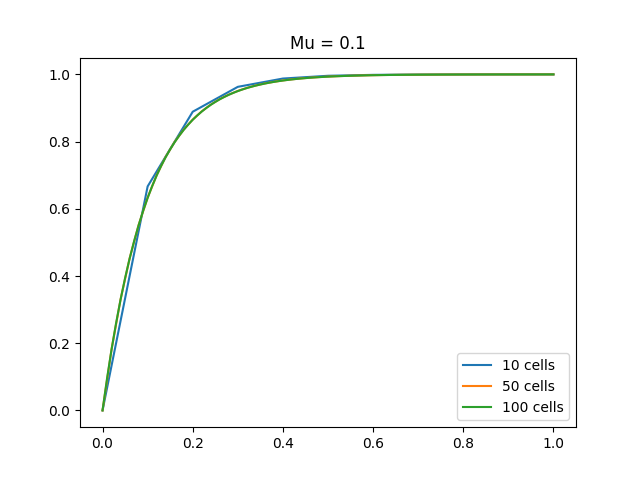

Mu = 0.01

-----------------

Mesh with h = 0.1
H1 error norm: 8.67e+00
L2 error norm: 1.92e-01

Constant C: 11.93249208625801

-----------------

Mesh with h = 0.02
H1 error norm: 3.81e+00
L2 error norm: 1.77e-02

Constant C: 26.68351693407297

-----------------

Mesh with h = 0.01
H1 error norm: 2.22e+00
L2 error norm: 4.79e-03

Constant C: 31.073209946483654

-----------------



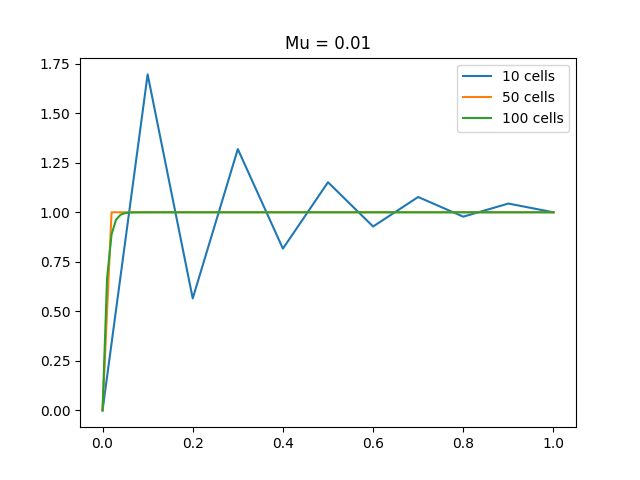

Mu = 0.001

-----------------

Mesh with h = 0.1
H1 error norm: 8.00e+01
L2 error norm: 2.50e+00

Constant C: 15.852875669096202

-----------------

Mesh with h = 0.02
H1 error norm: 3.46e+01
L2 error norm: 1.26e-01

Constant C: 77.3122091013401

-----------------

Mesh with h = 0.01
H1 error norm: 2.70e+01
L2 error norm: 5.95e-02

Constant C: 120.77946778483042

-----------------



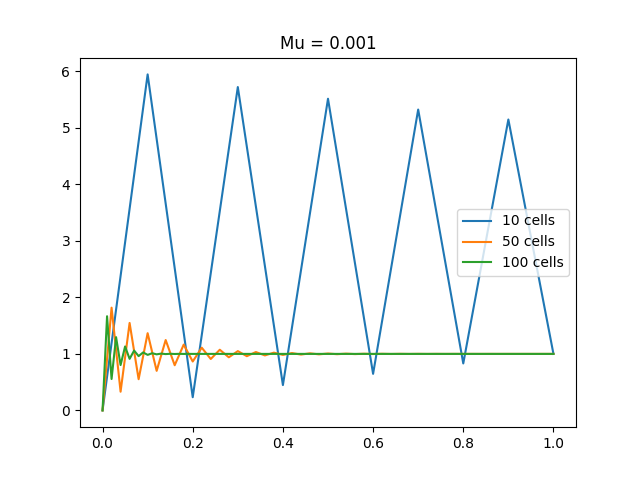

In [30]:
## Exercise 3.2

def left_boundary(x):
    ''' Locator function for the boundary at x = 0.
    '''
    return np.isclose(x[0], 0.0)

def right_boundary(x):
    ''' Locator function for the boundary at x = 1.
    '''
    return np.isclose(x[0], 1.0)


class u_analytical:
    ''' Class for the function expression of the analytical solution.
    '''
    def __init__(self, mu):
        self.mu = mu
        
    def __call__(self, x):
        return (np.exp(-x[0] / self.mu) - 1) / (np.exp(-1 / self.mu) - 1)
    
class du_analytical:
    ''' Class for the function expression of the derivative of the analytical solution.
    '''
    def __init__(self, mu):
        self.mu = mu
        
    def __call__(self, x):
        return np.exp(-x[0] / self.mu) / (self.mu * (1 - np.exp(-1 / self.mu)))

# Loop over different mesh resolutions
for mu_val in [1e-1, 1e-2, 1e-3]:
    plt.figure()
    plt.clf() # Clear previous plots
    plt.title(f'Mu = {mu_val}')
    print(f"Mu = {mu_val:g}\n")
    print("-----------------\n")
    for N in [10, 50, 100]:
        h = 1/N # Mesh resolution
        print(f"Mesh with h = {h}")
        mesh = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, N) # Unit interval mesh
        P1 = ufl.FiniteElement('CG', mesh.ufl_cell(), 1) # Linear Lagrange elements
        V = dfx.fem.FunctionSpace(mesh, P1)

        u, w = ufl.TrialFunction(V), ufl.TestFunction(V) # Trial and test functions
        mu = dfx.fem.Constant(mesh, PETSc.ScalarType(mu_val)) # Viscosity
        f = dfx.fem.Constant(mesh, PETSc.ScalarType(0.0)) # Source term
        v = dfx.fem.Constant(mesh, PETSc.ScalarType(-1)) # Velocity

        # Bilinear and linear forms
        a = (mu*u.dx(0)*w.dx(0) + v * u.dx(0) * w) * dx
        L = f * w * dx

        bc1_value = dfx.fem.Constant(mesh, PETSc.ScalarType(0))
        bc2_value = dfx.fem.Constant(mesh, PETSc.ScalarType(1))

        bc1_entities = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left_boundary)
        bc1_dofs = dfx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, bc1_entities)
        bc1 = dfx.fem.dirichletbc(bc1_value, bc1_dofs, V)

        bc2_entities = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right_boundary)
        bc2_dofs = dfx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, bc2_entities)
        bc2 = dfx.fem.dirichletbc(bc2_value, bc2_dofs, V)

        bcs = [bc1, bc2]

        problem = dfx.fem.petsc.LinearProblem(a, L, bcs = bcs,
                                              petsc_options = {"ksp_type": "preonly", "pc_type": "lu"})
        u_h = problem.solve()
        plt.plot(np.linspace(0, 1, N+1), u_h.x.array[:], label = f'{N} cells')
        H1_error = calc_H1_error(mu_val, u_h)
        L2_error = calc_L2_error(mu_val, u_h)
        print(f"H1 error norm: {H1_error:.2e}")
        print(f"L2 error norm: {L2_error:.2e}\n")
        
        # Estimate Cea's lemma constant
        u_H2_norm = calc_H2_norm(u_h)
        C = H1_error/(h * u_H2_norm)
        print(f"Constant C: {C}\n")
        print("-----------------\n")
        
    
    plt.legend()
    plt.show()



## Exercise 3.3

Implement the convection-diffusion problem with $f = -\alpha u_{xx} - u_x$, where $u = \sin{(\pi x)}$.

In [5]:
class fFunction:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, x):
        return self.fun(x[0])
    
    def fun(self, x):
        term1 = - self.alpha * (- np.pi ** 2 * np.sin(np.pi * x))
        term2 = - np.pi * np.cos(np.pi * x)
        return term1 + term2


Mu = 0.1

-----------------

Mesh with h = 0.1
H1 error norm: 2.02e-01
L2 error norm: 3.70e-01

Constant C: 0.8719963076271158

-----------------

Mesh with h = 0.02
H1 error norm: 4.03e-02
L2 error norm: 3.66e-01

Constant C: 0.8644867878673816

-----------------

Mesh with h = 0.01
H1 error norm: 2.01e-02
L2 error norm: 3.66e-01

Constant C: 0.8642537588464603

-----------------



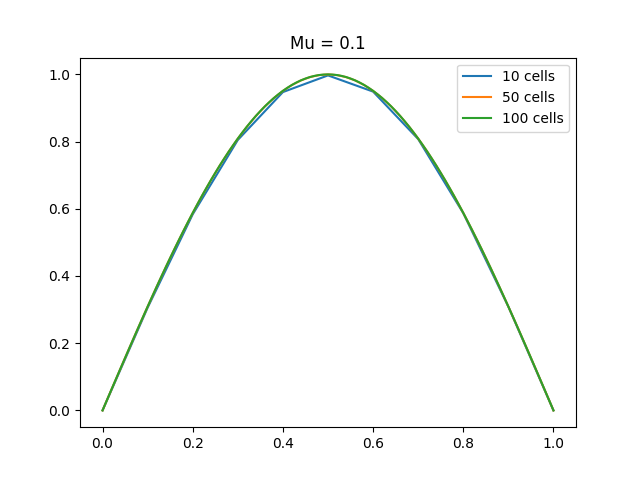

Mu = 0.01

-----------------

Mesh with h = 0.1
H1 error norm: 2.01e-01
L2 error norm: 4.64e-01

Constant C: 0.867514217573041

-----------------

Mesh with h = 0.02
H1 error norm: 4.03e-02
L2 error norm: 4.61e-01

Constant C: 0.8643103644001738

-----------------

Mesh with h = 0.01
H1 error norm: 2.01e-02
L2 error norm: 4.61e-01

Constant C: 0.8642096800279513

-----------------



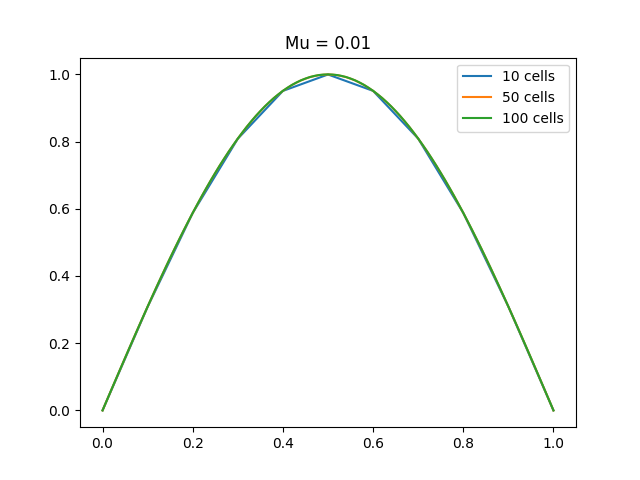

Mu = 0.001

-----------------

Mesh with h = 0.1
H1 error norm: 2.01e-01
L2 error norm: 4.73e-01

Constant C: 0.8672570148136095

-----------------

Mesh with h = 0.02
H1 error norm: 4.03e-02
L2 error norm: 4.75e-01

Constant C: 0.8642935108111681

-----------------

Mesh with h = 0.01
H1 error norm: 2.01e-02
L2 error norm: 4.75e-01

Constant C: 0.8642054692701279

-----------------



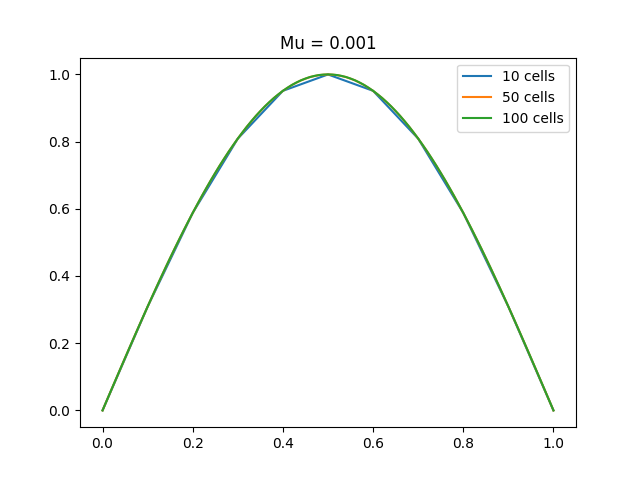

In [26]:
# Exercise 3.3

# Loop over different mesh resolutions
for mu_val in [1e-1, 1e-2, 1e-3]:
    plt.figure()
    plt.clf() # Clear previous plots
    plt.title(f'Mu = {mu_val}')
    print(f"Mu = {mu_val:g}\n")
    print("-----------------\n")
    for N in [10, 50, 100]:
        h = 1/N # Mesh resolution
        print(f"Mesh with h = {h}")
        mesh = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, N) # Unit interval mesh
        P1 = ufl.FiniteElement('CG', mesh.ufl_cell(), 1) # Linear Lagrange elements
        V = dfx.fem.FunctionSpace(mesh, P1)

        u, w = ufl.TrialFunction(V), ufl.TestFunction(V) # Trial and test functions
        mu = dfx.fem.Constant(mesh, PETSc.ScalarType(mu_val)) # Viscosity
        f = dfx.fem.Function(V) # Source term
        f_expr = fFunction(alpha = mu_val)
        f.interpolate(f_expr)
        v = dfx.fem.Constant(mesh, PETSc.ScalarType(-1)) # Convection velocity

        # Bilinear and linear forms
        a = (mu * u.dx(0) * w.dx(0) + v * u.dx(0) * w) * dx
        L = f * w * dx

        bc1_value = dfx.fem.Constant(mesh, PETSc.ScalarType(0))
        bc2_value = dfx.fem.Constant(mesh, PETSc.ScalarType(0))

        bc1_entities = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left_boundary)
        bc1_dofs = dfx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, bc1_entities)
        bc1 = dfx.fem.dirichletbc(bc1_value, bc1_dofs, V)

        bc2_entities = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right_boundary)
        bc2_dofs = dfx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, bc2_entities)
        bc2 = dfx.fem.dirichletbc(bc2_value, bc2_dofs, V)

        bcs = [bc1, bc2]

        problem = dfx.fem.petsc.LinearProblem(a, L, bcs = bcs,
                                              petsc_options = {"ksp_type": "preonly", "pc_type": "lu"})
        u_h = problem.solve()
        plt.plot(np.linspace(0, 1, N+1), u_h.x.array[:], label = f'{N} cells')
        H1_error = calc_H1_error(mu_val, u_h, MMS = True)
        L2_error = calc_L2_error(mu_val, u_h)
        print(f"H1 error norm: {H1_error:.2e}")
        print(f"L2 error norm: {L2_error:.2e}\n")
        
        # Estimate Cea's lemma constant
        u_H2_norm = calc_H2_norm(u_h)
        C = H1_error/(h * u_H2_norm)
        print(f"Constant C: {C}\n")
        print("-----------------\n")
        
    
    plt.legend()
    plt.show()


## Exercise 3.4

Implement the convection-diffusion problem with $f = -\alpha u_{xx} - u_x$, where $u = \sin{(\pi x)}$, using SUPG.

In [ ]:
# Exercise 3.3

#fig_idx = 1
t = 1 # Order of polynomials in approximation
beta_val = 0.5 # SUPG parameter
# Loop over different mesh resolutions
for mu_val in [1e-1, 1e-3, 1e-5]:
    plt.figure(fig_idx)
    plt.title(f'Mu = {mu_val}')
    print(f"Mu = {mu_val:g}\n")
    print("-----------------\n")
    for N in [10, 100]:
        h = 1/N # Mesh resolution
        print(f"Mesh with h = {h}")
        mesh = dfx.mesh.create_unit_interval(MPI.COMM_WORLD, N) # Unit interval mesh
        P1 = ufl.FiniteElement('CG', mesh.ufl_cell(), 1) # Linear Lagrange elements
        V = dfx.fem.FunctionSpace(mesh, P1)

        u, w = ufl.TrialFunction(V), ufl.TestFunction(V) # Trial and test functions
        mu = dfx.fem.Constant(mesh, PETSc.ScalarType(mu_val)) # Viscosity
        f = dfx.fem.Function(V) # Source term
        f_expr = fFunction(alpha = mu_val)
        f.interpolate(f_expr)
        v = dfx.fem.Constant(mesh, PETSc.ScalarType(-1)) # Velocity
        beta = dfx.fem.Constant(mesh, PETSc.ScalarType(beta_val))
        
        # Bilinear and linear forms
        a = (mu * u.dx(0) * w.dx(0) + v * u.dx(0) * w + 
             beta * h * v * u.dx(0) * v * w.dx(0) - beta * h * mu * div(grad(u)) * v * w.dx(0)) * dx
        L = (f * w + beta * h * v * w.dx(0))* dx

        bc1_value = dfx.fem.Constant(mesh, PETSc.ScalarType(0))
        bc2_value = dfx.fem.Constant(mesh, PETSc.ScalarType(1))

        bc1_entities = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, left_boundary)
        bc1_dofs = dfx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, bc1_entities)
        bc1 = dfx.fem.dirichletbc(bc1_value, bc1_dofs, V)

        bc2_entities = dfx.mesh.locate_entities_boundary(mesh, mesh.topology.dim - 1, right_boundary)
        bc2_dofs = dfx.fem.locate_dofs_topological(V, mesh.topology.dim - 1, bc2_entities)
        bc2 = dfx.fem.dirichletbc(bc2_value, bc2_dofs, V)

        bcs = [bc1, bc2]

        problem = dfx.fem.petsc.LinearProblem(a, L, bcs = bcs,
                                              petsc_options = {"ksp_type": "preonly", "pc_type": "lu"})
        u_h = problem.solve()
        plt.plot(np.linspace(0, 1, N+1), u_h.x.array[:], label = f'{N} cells')
        H1_error = calc_H1_error(mu_val, u_h)
        L2_error = calc_L2_error(mu_val, u_h)
        print(f"H1 error norm: {H1_error:.2e}")
        print(f"L2 error norm: {L2_error:.2e}\n")
        
        # Estimate Cea's lemma constant
        u_L2_norm = dfx.fem.assemble_scalar(dfx.fem.form(u_h ** 2 * dx))
        C = H1_error/(h**t * u_L2_norm)
        print(f"Constant C: {C}\n")
        print("-----------------\n")
        
    
    plt.legend()
    plt.show()
    fig_idx += 1
